In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP, plot_N, plot_N3D, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
from tools_lnd import make_lil_axes, same_stim_trial, generate_Beta_epoch, gen_X_from_model_dir_epoch
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [25]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']##################

rule_trains = ['fdgo','fdanti']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = '0'
lr = -7
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# net_name = 'lr7.0l2_w6.0_h-0.0_fdgo_fdanti'
data_folder = 'data/rnn/multitask/stepnet/lr'
m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [26]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig1','fig1_two_task_interp_no_text')
if not os.path.exists(figpath):
    os.makedirs(figpath)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_fdanti/0/model.ckpt


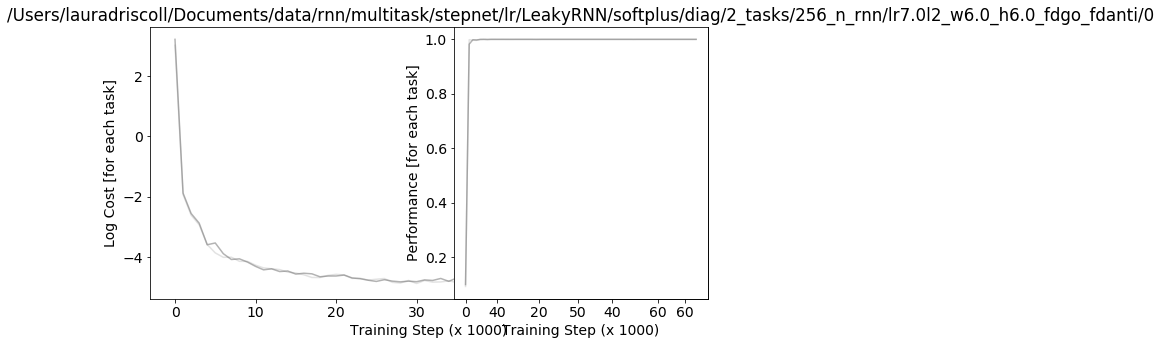

In [27]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp

fig = plt.figure(figsize=(10, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')
task_list = hparams['rule_trains']

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    
    ax1 = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)

    ax2 = fig.add_subplot(1,2,2)
    x = log_all['perf_'+task_list[r]]
    plt.plot(x,'-',c = c,alpha = .5)

ax1.set_xlabel('Training Step (x 1000)')
ax1.set_ylabel('Log Cost [for each task]')    
ax2.set_xlabel('Training Step (x 1000)')
ax2.set_ylabel('Performance [for each task]')
plt.title(m)
plt.show()    

In [28]:
#output dynamics
rule = rule_trains[0]
h,trial,tasks = make_h_trial_rule(m)
w_in, b_in, w_out, b_out = get_model_params(m)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_fdanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/

In [29]:
def get_filename_interp(trial1,trial2,epoch_list,t_set):
    n_stim_per_ring = int(np.shape(trial1.y)[2]-1)
    stim_size = int(2*n_stim_per_ring+1)

    rule1 = rules_dict['all'][np.argmax(trial1.x[0,0,stim_size:])]
    rule2 = rules_dict['all'][np.argmax(trial2.x[0,0,stim_size:])]
    ind_stim_loc1  = 180*trial1.y_loc[-1,t_set[0]]/np.pi
    ind_stim_loc2  = 180*trial2.y_loc[-1,t_set[1]]/np.pi
    filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(round(ind_stim_loc1,2))+'_x'+str(round(ind_stim_loc2,2))

    return filename

In [30]:
def get_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename, ind_stim_loc

In [41]:
from tools_lnd import same_mov_inds

def make_D_use(m,rule,epoch,ti,axs,trial_num = [0,0]):
    trial_str = '_'.join(str(t) for t in trial_num)
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    filename,_ = get_filename(trial,epoch,ti)
    f = os.path.join(m,'tf_fixed_pts_manytrials',rule,filename+'.npz')
    D_use = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
    return D_use

def interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov',tol_q = 1e-6,interp = True,
             cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['gainsboro','dimgray'],q_thresh = .001,
            n_skip_interps=2, rule_axs = 0, plot_unstable = True):
    
    fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 14})
    n_interp = 20
    
    if interp:
        trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
        trial2 = gen_trials_from_model_dir(m,rule_set[1],mode='test',noise_on = False)
        trial2 = same_mov_inds(trial1, trial2) 
        trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
        save_dir = os.path.join(m,script_name,rule_set[0]+'_'+rule_set[1],'tol_q_e_'+str(-np.log10(tol_q)))
        filename_interp = get_filename_interp(trial1,trial2,epoch_set,t_set)
        
        for step_i in range(n_interp-1,0,-n_skip_interps):
            c = cmap_grad(step_i/n_interp)

            fp_dir = os.path.join(m,script_name,rule_set[0]+'_'+rule_set[1],'tol_q_e_'+str(-np.log10(tol_q)),
                                  filename_interp+'_step_'+str(step_i)+'.npz')
            fp_struct = np.load(fp_dir)
            step_fps = fp_struct['xstar']
            fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
            J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
            sorted_fps = fp_struct['xstar'][fp_inds,:]
            eig_decomps = comp_eig_decomp(J_xstar)

            for fp_ind in range(len(fp_inds)):

                fp = np.dot(sorted_fps[fp_ind,:],D_use)
                
                if np.max(eig_decomps[fp_ind]['evals'])>.99:
                    markerfacecolor = 'None'
                    al = .3
                    if plot_unstable:
                        plt.plot(fp[0],fp[1],'o',c = c,linewidth = 10,markersize = 20,markerfacecolor = markerfacecolor,
                                 alpha = al)
                else:
                    markerfacecolor = c
                    c = 'w'
                    al = .5
                    plt.plot(fp[0],fp[1],'o',c = c,linewidth = 10,markersize = 20,markerfacecolor = markerfacecolor,
                             alpha = al)

    for ri in range(2):

        rule = rule_set[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]

        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

        ax = plt.subplot(111)

        plot_N(x_epoch[trial_set,:,:],D_use.T,trial.stim_locs[trial_set,0],
               linewidth = 6,linestyle = '-', alpha = .5, markersize = 20)
        plot_N(x_epoch[trial_set,:,:],D_use.T,[cmap_discrete[ri],],linewidth = 2, 
               linestyle =  '-', alpha = .9, markersize = 10)
        
#     ax.set_xlim([-1.2,1.2])
#     ax.set_ylim([-1.2,1.2])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.axis('off')

    fig_fldr = 'interp_fps'
    if not os.path.exists(os.path.join(figpath,fig_fldr)):
        os.makedirs(os.path.join(figpath,fig_fldr))

    tit_name = rule_set[0]+'_v_'+rule_set[1]+'_'+epoch+'_dynamics'
    plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'))
    plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
    plt.show()

In [42]:
def interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov',tol_q = 1e-6,interp = True,
             cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['gainsboro','dimgray'],q_thresh = .001,
            n_skip_interps=1, rule_axs = 0, plot_unstable = True,plot_zero_plane = False):
    
    fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
    ax = fig.add_axes([0,0,1,1], projection='3d');
    n_interp = 20
    
    
    if interp:
        trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
        trial2 = gen_trials_from_model_dir(m,rule_set[1],mode='test',noise_on = False)
        trial2 = same_mov_inds(trial1, trial2) 
        trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
        save_dir = os.path.join(m,script_name,rule_set[0]+'_'+rule_set[1],'tol_q_e_'+str(-np.log10(tol_q)))
        filename_interp = get_filename_interp(trial1,trial2,epoch_set,t_set)

    for ri in range(2):

        rule = rule_set[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]

        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

        plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,trial.stim_locs[trial_set,0],
               linewidth = 6,linestyle = '-', alpha = .5, markersize = 100)
        plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,[cmap_discrete[ri],],linewidth = 2, 
               linestyle =  '-', alpha = .9, markersize = 100)

    if interp:
        for step_i in range(n_interp-1,0,-n_skip_interps):
            c = cmap_grad(step_i/n_interp)

            fp_dir = os.path.join(m,script_name,rule_set[0]+'_'+rule_set[1],'tol_q_e_'+str(-np.log10(tol_q)),
                                  filename_interp+'_step_'+str(step_i)+'.npz')
            fp_struct = np.load(fp_dir)
            step_fps = fp_struct['xstar']
            fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
            J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
            sorted_fps = fp_struct['xstar'][fp_inds,:]
            eig_decomps = comp_eig_decomp(J_xstar)

            for fp_ind in range(len(fp_inds)):

                fp = np.dot(sorted_fps[fp_ind,:],D_use)
                
                if np.max(eig_decomps[fp_ind]['evals'])>1:
                    markerfacecolor = 'w'
                    edgecolors = c
                    al = .5
                    
                    if plot_unstable:
                        ax.scatter(fp[0],fp[1],fp[2],s = 200,marker = 'o',edgecolors = edgecolors,
                           facecolors = markerfacecolor,alpha = al)

                else:
                    markerfacecolor = c
                    edgecolors = 'w'
                    al = .5
                    ax.scatter(fp[0],fp[1],fp[2],s = 200,marker = 'o',edgecolors = edgecolors,
                           facecolors = markerfacecolor,alpha = al)

    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    if plot_zero_plane:
        xx, yy = np.meshgrid(np.linspace(x1, x2, num=2), np.linspace(y1, y2, num=2))
        z = xx*0
        ax.plot_surface(xx, yy, z, alpha=0.1)
    ax.set_zlim([-1.1,1.1])
#     ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([-1,1])
    ax.set_zticklabels([-1,1],fontsize = 20)
#     plt.axis('off')

    fig_fldr = 'interp_fps'
    if not os.path.exists(os.path.join(figpath,fig_fldr)):
        os.makedirs(os.path.join(figpath,fig_fldr))
    
    tit_name = rule_set[0]+'_v_'+rule_set[1]+'_'+epoch+'_dynamics'
    plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'))
    plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
    plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_fdanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32

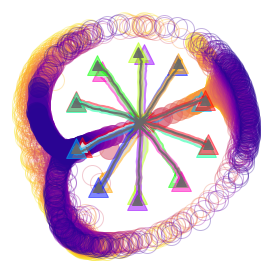

In [38]:
offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = ['fdgo','fdanti']
epoch_set = ['stim1','stim1']
script_name = 'interp_tasks_small_init_stim'
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = True

rule_axs = 0
epoch = epoch_set[rule_axs]
rule = rule_set[rule_axs]
ti = trial_num[rule_axs]
D_use = make_D_use(m,rule,epoch,ti,axs)

interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = .0001,rule_axs = rule_axs, plot_unstable = True, n_skip_interps=1)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_fdanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32

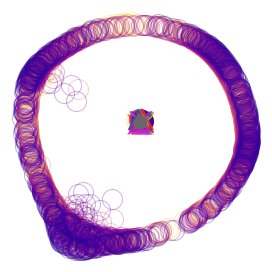

In [39]:
epoch_set = ['fix1','fix1']
script_name = 'interp_tasks_small_init_mov'

# rule_axs = 0
# epoch = epoch_set[rule_axs]
# rule = rule_set[rule_axs]
# ti = trial_num[rule_axs]
# D_use = make_D_use(m,rule,epoch,ti,axs)

interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = .0001,rule_axs = rule_axs, plot_unstable = True, n_skip_interps=1)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_fdanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32

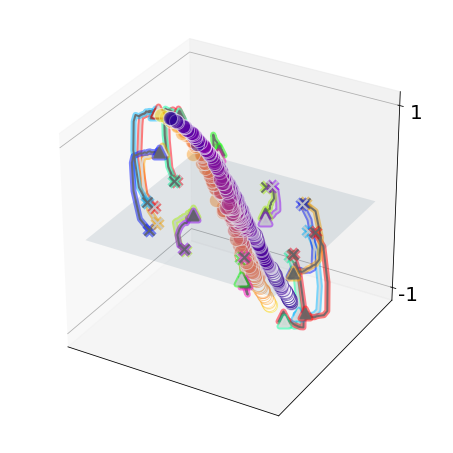

In [43]:
epoch_set = ['go1','go1']
script_name = 'interp_tasks_small_init_mov'

D_use[:,2] = w_out[:,2]

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = .0001,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,plot_zero_plane = True)